## Create Player Groups

This notebook takes the output from the Feature_Engineering notebook and extends it by clustering the players into groups. The idea behind this analysis is that there are different types of batters in baseball, there are ones that try to hit a lot of home runs, ones that are better at hitting for average, and the rare players that can do both. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/all_batters_with_feats.csv')

In [4]:
feats = ['is_home','hit_streak','prev_points','points_ma','above_avg_streak']

### Create a player type column

Create some clustering to group similar players into clusters.

For example hitters with high home runs and low average may have a very different way of predicting their fantasy points than a hitter that has a high average with low home runs

In [5]:
season_totals_df = df.groupby('player_id').sum()[['H','2B','3B','HR', 'AB']].reset_index()

In [6]:
season_totals_df['avg'] = season_totals_df['H']/season_totals_df['AB']

In [7]:
cleaned_df = season_totals_df[season_totals_df['AB']>=38]

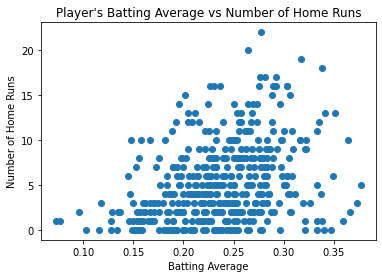

In [8]:
plt.scatter(cleaned_df['avg'], cleaned_df['HR'])
plt.xlabel("Batting Average")
plt.ylabel("Number of Home Runs")
plt.title("Player's Batting Average vs Number of Home Runs")
plt.show()

In [9]:
X = cleaned_df[['avg','HR']]
sse = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    sse.append(kmeans.inertia_)


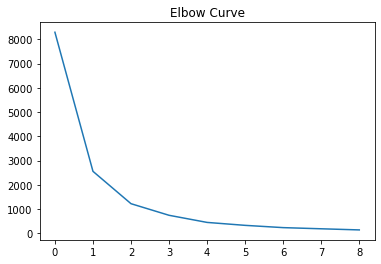

In [10]:
plt.plot(sse)
plt.title("Elbow Curve")
plt.show()

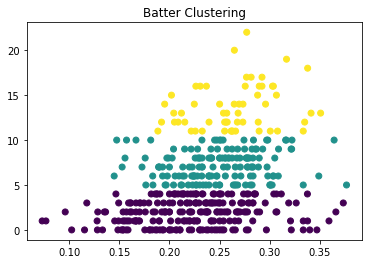

In [11]:
X = cleaned_df[['avg','HR']]

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

plt.scatter(cleaned_df['avg'], cleaned_df['HR'], c=kmeans.labels_)
plt.title("Batter Clustering")
plt.show()

In [12]:
hitter_type_df = cleaned_df.copy()
d = {0: 'low_home_runs', 1: 'med_home_runs', 2:'high_home_runs'}
hitter_type_df['hitter_type'] = [d[label] for label in kmeans.labels_]

In [13]:
final_df = pd.concat([hitter_type_df, pd.get_dummies(hitter_type_df['hitter_type'])], axis=1)

### Add cluster to dataframe, for the batter's that qualified 

* I filtered out the players that had less than 38 at bats because that was the 25th percentile of at bats

In [14]:
hitter_type_df = pd.merge(final_df[['player_id','high_home_runs', 'low_home_runs', 'med_home_runs']], df, left_on='player_id',right_on='player_id')

In [15]:
hitter_type_df.to_csv('../data/all_batters_with_extra_feats.csv', index=False)